##### Elevation difference dataset is inflicted by outliers which affect the mass budget estimates..
### Several approaches exist to identify and remove the outliers
##### This code identifies and removes the outliers based on a sigmoidal "non-linear" relationship between elevation and elevation difference values in a basin...
### For further reading refer to Pieczonka and Bolch 2015, Global and Planetry Changes https://doi.org/10.1016/j.gloplacha.2014.11.014


In [1]:
#importing the libraries required for the evaluation
import numpy as np
import rasterio
from pygeotools.lib import malib, warplib, iolib
import numpy.ma as ma
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
fn1='Elevation.tif' #Elevation_dataset, it is assumed that both the elevation and dh rasters are clipped to glacier extents
fn2='dh_glaciers.tif' #Elevation_difference dataset
ds_list=warplib.memwarp_multi_fn([fn1,fn2],res='max',extent='intersection',t_srs='first', r='cubic')
A=iolib.ds_getma(ds_list[0])
dh=iolib.ds_getma(ds_list[1])
E=ma.asarray(A,dtype=np.float32)



Warping all inputs to the following:
Resolution: 30.0
Extent: [594711.267, 3697416.167, 631071.267, 3753786.167]
Projection: '+proj=utm +zone=43 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: Elevation.tif
2 of 2: dh_glaciers.tif


#### Calculating min elevation, max elevation, standard deviation for dh

In [4]:
Max_Elevation=ma.max(E)
Min_Elevation=ma.min(E)
Std_dh=ma.std(dh)
print "Max glacier Elevation of Sample is " + str(Max_Elevation)
print "Min glacier Elevation of Sample is " + str(Min_Elevation)
print "Standard deviation of entire unfiltered dh sample is " + str(Std_dh)


Max glacier Elevation of Sample is 6563.0
Min glacier Elevation of Sample is 3513.0
Standard deviation of entire unfiltered dh sample is 17.3892542359


#### As you can see the publications which have used this equation highlight the dependance of the wieghts used in equation to the overall glacier's dh standard deviation and the range of glacier elevations in the basin, so this codes geneate filtered values based on weights=5 to 10, however, the user may tweek the values if the results are not satisfactory

running loop for weight =5
Stats for permissible values using wieght 5
count: 649259 min: 0.06 max: 3.53 mean: 0.41 std: 0.36 med: 0.29 mad: 0.16 q1: 0.21 q2: 0.46 iqr: 0.25 mode: 0.29 p16: 0.18 p84: 0.59 spread: 0.20
Stats for filtered dh raster using weight 5
count: 11922 min: -3.18 max: 2.97 mean: -0.03 std: 0.46 med: -0.00 mad: 0.25 q1: -0.19 q2: 0.16 iqr: 0.34 mode: -0.25 p16: -0.26 p84: 0.23 spread: 0.25
running loop for weight =6
Stats for permissible values using wieght 6
count: 649259 min: 0.19 max: 21.94 mean: 1.88 std: 2.10 med: 1.21 mad: 0.76 q1: 0.80 q2: 2.04 iqr: 1.24 mode: 1.18 p16: 0.67 p84: 2.76 spread: 1.05
Stats for filtered dh raster using weight 6
count: 54066 min: -17.59 max: 15.84 mean: -0.95 std: 2.83 med: -0.29 mad: 1.25 q1: -1.26 q2: 0.49 iqr: 1.75 mode: -7.91 p16: -2.38 p84: 0.81 spread: 1.59
running loop for weight =7
Stats for permissible values using wieght 7
count: 649259 min: 0.57 max: 97.40 mean: 8.17 std: 10.18 med: 4.79 mad: 3.38 q1: 2.95 q2: 8.70 iqr

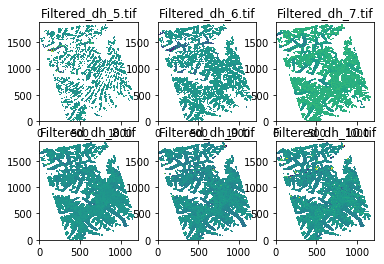

In [10]:
for i in range (5,11,1):
    print "running loop for weight =" + str (i)
    w=(Max_Elevation - Min_Elevation)/E
    C_std=i-i*np.tanh(2*3.14-i*w)
    R_dh=C_std*Std_dh
    print "Stats for permissible values using wieght %d" %i
    malib.print_stats(R_dh)
    test=np.logical_and(dh.__gt__(-R_dh), dh.__lt__(R_dh))
    s=dh*test
    Final=ma.masked_where(s == 0, s)
    print "Stats for filtered dh raster using weight %d" %i
    malib.print_stats(Final)
    string = str(i)
    out_fn = 'Filtered_dh_%d.tif' %i
    iolib.writeGTiff(Final, out_fn, ds_list[0])
    plt.subplot(2,3,(i-4))
    plt.pcolormesh(Final)
    plt.title(out_fn)
    